# Alchemical free energy setup


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Authors:   
[Antonia Mey -- @ppxasjsm](https://github.com/ppxasjsm)   
[Lester Hedges -- @lohedges](https://github.com/lohedges)

## Learning objectives:
- Setup an alchemical solvation free energy simulation using BioSimSpace and SOMD
- Setup an alchemical solvation free energy simulation using BioSimSpace and Gromacs
- Setup an alchemical binding free energy simulation for Gromacs and SOMD using BioSimSpace

You will be using the following functions in BioSimSpace:

- `BSS.IO.readMolecules()` To load the molecules
- `BSS.Parameters.gaff` To parameterise molecules using the Generalised Amber Force Field (GAFF)
- `BSS.Parameters.ff14SB` To parameterise a protein using FF14SB
- `BSS.Align.matchAtoms()` Maximum Common Substructure matches atoms for the morphing
- `BSS.Align.rmsdAlign()` Aligns the molecules to be morphed
- `BSS.Align.merge()` Creates a merged molecule used for alchemical simulations
- `BSS.Solvent.tip3p()` Solvates a molecule in a tip3 water box
- `BSS.Protocol.FreeEnergy()` Defines the free energy protocol
- `BSS.FreeEnergy.Relative()` Sets up a leg for a relative free-energy simulation


**Reading time**:
~ 30 mins

**Jupyter cheat sheet**:
- To run the currently highlighted cell and move focus to the next cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To run the currently highlighted cell and keep focus in the same cell, hold <kbd>&#x21E7; Ctri</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- You can find the full documentation at [biosimspace.org](https://biosimspace.org).

## Table of Contents
1. [Working with ligands](#lig)    
   1.1 [Loading ligands](#load)   
   1.2 [Parametrising ligands](#param)   
2. [Morphing ligands](#merge)   
   2.1 [MCS](#mcs)   
   2.2 [morphed ligand](#morph)   
3. [Running solvation free energy simulation](#solv)
4. [Binding free energy simulation](#bind)   
5. [Exercises](#exerc2)   

First, let's import BioSimspace!

In [1]:
import BioSimSpace as BSS

## 1. Free energy of solvation of ethane and methanol
<a id="lig"></a>

We want to compute the relative free energy of hydration between ethane and methanol. That is the free energy difference between hydrating an ethane molecule in water and a methanol molecule in water. (For reference, refer to the [slides](slides/CCPBioSim-FEP-tutorial.pdf)).

Below you can see a thermodynamic cycle for the relative hydration free energy of ethane and methanol:
![therm_cycle](images/Therm_cycle.png)

### 1.1 Loading ligands
<a id="load"></a>
Next, we read in the two molecules we want to perturb. In this case, this is ethane changing to methanol. You can use the BioSimSpace function `BSS.IO.readMolecules()` for this task.

In [2]:
# We assume the molecules to perturb are the first molecules in each system. (Each file contains a single molecule.)
ethane = BSS.IO.readMolecules("input/ethane.pdb")[0]
methanol = BSS.IO.readMolecules("input/methanol.pdb")[0]

It might be nice to quickly check we are reading in the right molecules so we can visualise them using the `View` class from `BSS.Notebook`.

In [3]:
BSS.Notebook.View("input/ethane.pdb").system()

ThemeManager()

NGLWidget(gui_style='ngl')

In [4]:
BSS.Notebook.View("input/methanol.pdb").system()

NGLWidget(gui_style='ngl')

### 1.2 Parametrising molecules
<a id="param"></a>

Current we only have the coordinates information saved for the loaded molecules so the first thing we need to do is generated some forcefield parameters. In this case, we will use the Generalise Amber Force Field [(GAFF)](http://ambermd.org/antechamber/gaff.html).

In [5]:
ethane = BSS.Parameters.gaff(ethane).getMolecule()
methanol = BSS.Parameters.gaff(methanol).getMolecule()

## 2. Creating merged system
<a id="merge"></a>
Now ethane and methanol have all the required properties for running an MD simulation of them individually. But here we are interested in creating a morphed system, or `single topology` for running an alchemical free energy calculation. In this case, two of the ethane hydrogens will turn into dummy atoms and the second carbon and the 3rd hydrogen will turn into the `OH` group of the methanol. 

### 2.1 Maximum Common Substructure (MCS)
<a id="MCS"></a>
In order to automatically figure out which atoms are common between ethane and methanol we can use the `matchAtoms()` function of BioSimSpace. This will compute a Maxmimum Common Substructure (MCS) match and return a dictionary that maps the indices of atoms in the ethane molecule to the indices of the atoms in the ethanol to which they match. An example of what and MCS match might look like is shown here:
![MCS](images/MCS.png)


In [6]:
mapping = BSS.Align.matchAtoms(ethane, methanol)

# Mapping is a dictionary mapping atom indices in ethane to those in methanol.
print(mapping)

{0: 0, 2: 1, 1: 2, 6: 5, 3: 4, 4: 3}


Once we have the mapping we can align the molecules to each other using a root mean squared displacemnt (RMSD) metric and from the alignment we can then create a merged molecule which contains all of the `single topology` information needed for the alchemical perturbation.

To visualise the mapping we can use:

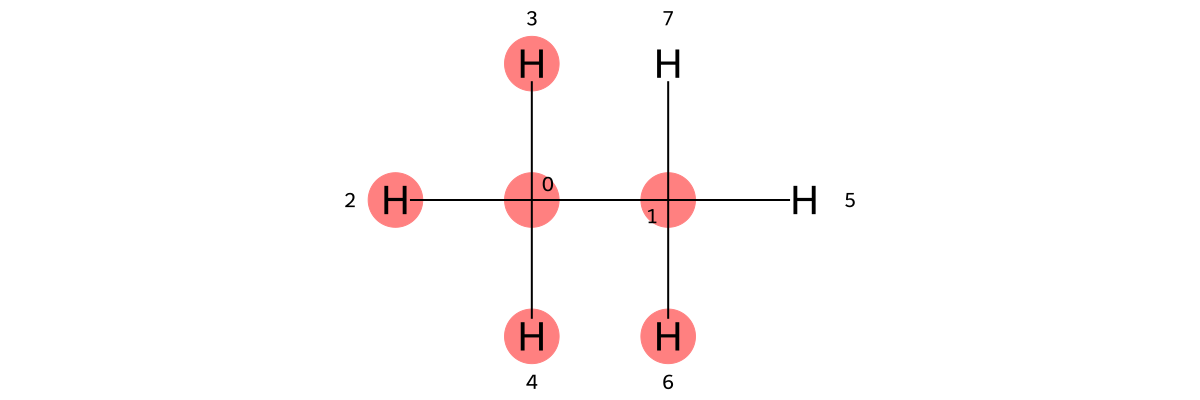

In [15]:
BSS.Align.drawMapping(ethane, methanol, mapping)

This shows ethane, with the atoms that map to those in methanol highlighted in red. The numbers next to the atoms are their indices within the molecule (and mapping dictionary).To instead use methanol as the reference, we can swap the order of the molecules that are passed to the function and invert the mapping dictionary:

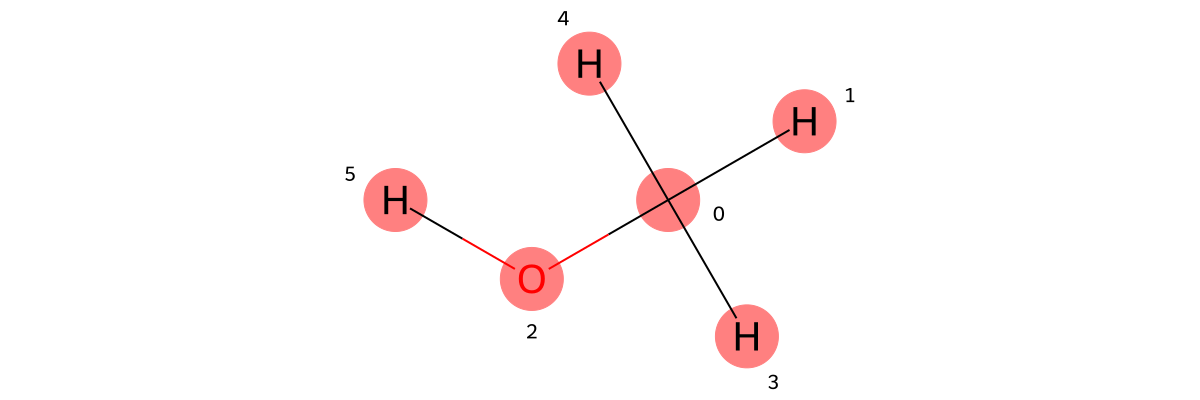

In [16]:
BSS.Align.drawMapping(methanol, ethane, {v:k for k,v in mapping.items()})

### 2.2 Creating a _merged_ molecule

In order to perform an alchemical simulation we need to create a _merged_ molecule that combines that properties of the two molecules. To do so we first need to align one molecule to the other, based on the mapping. This can be achieved using the `rsmdAlign` function:

In [17]:
# Align ethane to methanol based on the mapping.
ethane = BSS.Align.rmsdAlign(ethane, methanol, mapping)

We can now _merge_ the two molecules. This will create a composite molecule containing all of the molecular properties at both end states. If the molecules are a different size, then the smaller will contain dummy atoms to represent the atoms that will _appear_ during the perturbation. In this case, the merged methanol end state will contain two dummy atoms corresponding to the extra hydrogen atoms in the ethane molecule.

In [18]:
# Merge the ethane and methanol based on the mapping.
merged = BSS.Align.merge(ethane, methanol, mapping)

### 2.3 Solvation
<a id="solv"></a>

Before we can run a free energy simulation we will have to solvate the system. In this case, rather than passing ethane and methanol separately we will solvate the whole merged system. Here we use a cubic box with a base length of 40 Angstroms.

In [19]:
solvated = BSS.Solvent.tip3p(molecule=merged, box=3*[40*BSS.Units.Length.angstrom])

### 2.4 Reading and writing perturbable systems

You might wish to save a perturbable system to file for use in a future simulation, or to share with a colleague. To do so you can use the `BioSimSpace.IO.savePerturbableSystem` function. This writes the topology and coordinate files for the two end states, which can be read back to reconstruct the system. For example:

In [20]:
BSS.IO.savePerturbableSystem("pert", solvated)

There should now be four new AMBER format files in your working directory:

In [21]:
! ls pert*

pert0.prm7  pert0.rst7	pert1.prm7  pert1.rst7


Here `pert0.prm7` and `pert1.prm7` are the topology files for the two end states and `pert0.rst7` and `pert1.rst7` are the coordinates. To re-load the files we can use:

In [22]:
solvated = BSS.IO.readPerturbableSystem("pert0.prm7", "pert0.rst7", "pert1.prm7", "pert1.rst7")

## 3. Solvation free energy
<a id="free"></a>
We now need to define a protocol to describe the parameters used for the free energy perturbation. A simple protocol consists of a 2 fs timestep a runtime of 4 ns and using equally spaced 9 $\lambda$ windows:

In [23]:
protocol = BSS.Protocol.FreeEnergy(timestep=2*BSS.Units.Time.femtosecond, runtime=4*BSS.Units.Time.nanosecond, num_lam=9)

Next we want to create objects to configure and run the two legs associated with the relative free-energy perturbation calculation:

In [24]:
fep_free = BSS.FreeEnergy.Relative(solvated, protocol, work_dir="ethane_methanol_somd/free")
fep_vac  = BSS.FreeEnergy.Relative(merged.toSystem(), protocol, work_dir="ethane_methanol_somd/vacuum")

Decoupling the two legs means that we can use a different protocol for each, e.g. less lambda windows for the vacuum leg, or re-use data from a leg in an entirely different calculation, e.g. for a binding free-energy simulation, or to combine results for legs that were run with entirely simulation engines, e.g. SOMD or GROMACS.

To run simulations for all of the individual lambda windows for the free leg, you can use:

`fep_free.run()`   

This only makes sense on a workstation with GPUs or GPU cloud resources or a GPU cluster. Otherwise you will have to wait for too long to run these simulations on the notebook server.

Let's have a look the `ethane_methanol_somd/free` directory. In this directory you have now all the files setup and ready for simulation using SOMD as the simulation engine, which is the default.

In [ ]:
! ls ethane_methanol_somd/free

### 3.1. Exercises
<a id="exerc1"></a>

The exercises are announced by the keyword **Exercise** and followed by an incomplete cell.
Missing parts are indicated by:

```python
#FIXME
```

### 3.1.1. Exercise on selecting lambda windows

Above we defined a protocol with 9 $\lambda$ windows. For this system this isn't an optimal protocol and we would like to instead use 12 lambda window. Can you write down a protocol that would allow you to run 12 rather than 9 lambda windows?

In [ ]:
protocol = BSS.Protocol.FreeEnergy(#FIXME)

### 3.1.2. Exercise on merged molecules
Previously we have set up an ethane to methanol alchemical free energy simulation. One way of assessing how good an estimate of a free energy difference from an alchemical simulation is by running the simulation in the opposite direction, i.e. methanol to ethane. Can you set up a new merged molecule and run the necessary steps for the free energy setup?

In [ ]:
mapping = #FIXME

# Align methanol to ethane based on the mapping.
methanol = BSS.Align.rmsdAlign(#FIXME)

# Merge the two molecules based on the mapping.
merged_methanol = #FIXME
solvated_methanol = #FIXME
freenrg_methanol = #FIXME

### 3.1.3. Exercise on using different simulation engines

Currently, alchemical free energy simulations with SOMD and Gromacs are supported. Can you figure out how to setup and run the simulations for the free leg using GROMACS rather than the default of SOMD?

**Hint**: look at the `engine` keyword of `FreeEnergy.Relative()`. You might also want to change the working directory.

In [ ]:
fep_gromacs_free = BSS.FreeEnergy.Relative(#FIXME)

You will notice that again in your `work_dir`, two directories were created `free` and `vacuum`. Have a look at the content of these directories. You will notice that the input files that were generated are now indeed for GROMACS and not SOMD. Take a moment to look at the config files etc, e.g.:

In [ ]:
! ls ethane_methanol_gromacs/free/lambda_0.000

## 4. Free energy of binding
<a id="bind"></a>

So far we have done a setup for free energies of hydration. Next we'll learn how to use BioSimSpace to set up alchemical free energy simulations that can be used to compute free energies of binding. The thermodynamic cycle for the free energy of binding looks like this:

![reltherm](images/thermo_cycle_rel_eq.png)

In our case the host is Lysozyme, an antimicrobial protein, which has been studied extensivley using alchemical free energy calculations in the past.  

### 4.1 Loading the protein and ligands
Loading the protein is done in the same way as loading the small molecules. However, in order to compute free energies of binding, we have to make sure that the ligand is aligned with the protein and in an appropriate binding site. BioSimSpace is not a docking program. Therefore ligands will have to be aligned for alchemical free energy calculations in a different way. First, we will load the protein and ligands to check if they are aligned correctly for the calculation. 

In [ ]:
# Load the protein and two ligands.
lysozyme = BSS.IO.readMolecules("input/protein.pdb")[0]
benzene = BSS.IO.readMolecules("input/benzene.mol2")[0]
o_xylene = BSS.IO.readMolecules("input/o-xylene.mol2")[0]

In [ ]:
# Combine the molecules into a single container.
molecules = lysozyme + benzene + o_xylene

In [ ]:
# Create a view to visualise the molecules.
view = BSS.Notebook.View(molecules)
# View the entire system.
view.system()

### 4.2 Parametrisation
<a id="param"></a>

For the protein, we can use a standard Amber forcefield such as `Amber 14 SB`:

In [ ]:
lysozyme = BSS.Parameters.ff14SB(lysozyme).getMolecule()

For the two ligands we can chose to parametrise them using `gaff2`. 

In [ ]:
benzene = BSS.Parameters.gaff2(benzene).getMolecule()
o_xylene = BSS.Parameters.gaff2(o_xylene).getMolecule()

### 5.3 Morphing again

Now all we have to do is go back through the morphing process and then combine the system. 

In [ ]:
mapping = BSS.Align.matchAtoms(o_xylene, benzene)

In [ ]:
# Align o_xylene to benzene based on the mapping.
o_xylene = BSS.Align.rmsdAlign(o_xylene, benzene, mapping)

# Merge the two ligands based on the mapping.
merged = BSS.Align.merge(o_xylene, benzene, mapping)

Next we need to create a composite system containing the merged molecule and the protein:

In [ ]:
complx = merged + lysozyme

### 5.4 Binding free energy simulation
Now we can solvate and set up the binding free energy simulation. It looks very similar to the solvation one.

In [ ]:
# Solvate the protein ligand complex in a 60 angstrom box of TIP3P water.
complex_sol = BSS.Solvent.tip3p(molecule=complx, box=3*[60*BSS.Units.Length.angstrom])

# Solvate the merged ligand in a 60 angstrom box of TIP3P water.
merged_sol = BSS.Solvent.tip3p(molecule=merged, box=3*[60*BSS.Units.Length.angstrom])

# Create the free energy protocol.
protocol = BSS.Protocol.FreeEnergy(runtime=4*BSS.Units.Time.nanosecond, num_lam=9)

# Initialise relative free energy objects for each leg.
# (Once again, this defaults to the SOMD engine.)
fep_bound = BSS.FreeEnergy.Relative(complex_sol, protocol, work_dir="o_xylene_benzene/bound" )
fep_free  = BSS.FreeEnergy.Relative(merged_sol, protocol, work_dir="o_xylene_benzene/free" )

`fep_bound.run()`
Would run the simulation for the _bound_ leg.. 

### 5.5 Exercises
<a id="exerc2"></a>
Exercises for binding free energies. 

### 5.5.1 Box sizes of the solvated leg
One thing you can notice is that the box size of the bound and free leg are the same. This of course is a bit silly, because you don't need to use such a large box for just running the ligand in water. Since the two legs are decoupled, we can just solvate the ligand in a smaller box for the free leg.

In [ ]:
# Solvate the ligand in a smaller 30 angstrom box of TIP3P water.
merged_sol = #FIXME

# Recreate the object using the smaller system.
fep_free = BSS.FreeEnergy.Relative(merged_sol, protocol, work_dir="o_xylene_benzene/free")

### 5.5.2. Running a minimisation and equilibration before the production

It is good practice to minimise and equilibrate the molecular system _before_ setting up the free energy simulations. Thankfully BiomSpace can handle systems containing perturbable molecules for simulation protocols other than `BioSimSpace.Protocol.FreeEnergy`. For example, this means that you can create a process to minimise a specified end state (lambda = 0 by default) of a perturbable system. In the box below, write some code to run a minmisation and equilibration on the system (`complx`).

**Hint**: use the [documentation](https://biosimspace.org/). Also when returning the system use `getSystem(block=True)` so that we wait for the minimisation and equilibration simulations to finish before returning the system.

In [ ]:
minimised = #FIXME
equilibrated = #FIXME

# Create the free energy protocol.
protocol = BSS.Protocol.FreeEnergy(runtime=4*BSS.Units.Time.nanosecond, num_lam=9)

# Initialise relative free energy objects for each leg.
fep_bound = BSS.FreeEnergy.Relative(equilibrated, protocol, work_dir="exercise_5_3/bound")